DNN으로 집값 예측하기. 2022년 1월 8일 김이룸

In [ ]:
# 1번 셀

# 패키지 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# 2번 셀

# Hyperparameters
MY_HIIDEN = 1000   # 은닉층 뉴런 수
MY_EPOCH = 10      # 반복 학습 수

In [ ]:
# 3번 셀

# 데이터 파일 읽기
data = pd.read_csv('/content/drive/MyDrive/my-data/housing.csv') # 506 rows 13cols
# pd.set_option('display.max_columns', None) # 판다스 테이블 출력 시 생략하는 컬럼을 방지하는 옵션 
print(data.head())

def skip_three_rows():
  for i in range(3):
    print()
skip_three_rows()

# 데이터 통계 출력
print(data.describe())

      CRIM    ZN  INDUS  CHAS    NOX  ...  RAD  TAX  PTRATIO  LSTAT  MEDV
0  0.00632  18.0   2.31     0  0.538  ...    1  296     15.3   4.98  24.0
1  0.02731   0.0   7.07     0  0.469  ...    2  242     17.8   9.14  21.6
2  0.02729   0.0   7.07     0  0.469  ...    2  242     17.8   4.03  34.7
3  0.03237   0.0   2.18     0  0.458  ...    3  222     18.7   2.94  33.4
4  0.06905   0.0   2.18     0  0.458  ...    3  222     18.7   5.33  36.2

[5 rows x 13 columns]



             CRIM          ZN       INDUS  ...     PTRATIO       LSTAT        MEDV
count  506.000000  506.000000  506.000000  ...  506.000000  506.000000  506.000000
mean     3.613524   11.363636   11.136779  ...   18.455534   12.653063   22.532806
std      8.601545   23.322453    6.860353  ...    2.164946    7.141062    9.197104
min      0.006320    0.000000    0.460000  ...   12.600000    1.730000    5.000000
25%      0.082045    0.000000    5.190000  ...   17.400000    6.950000   17.025000
50%      0.256510    0.000000   

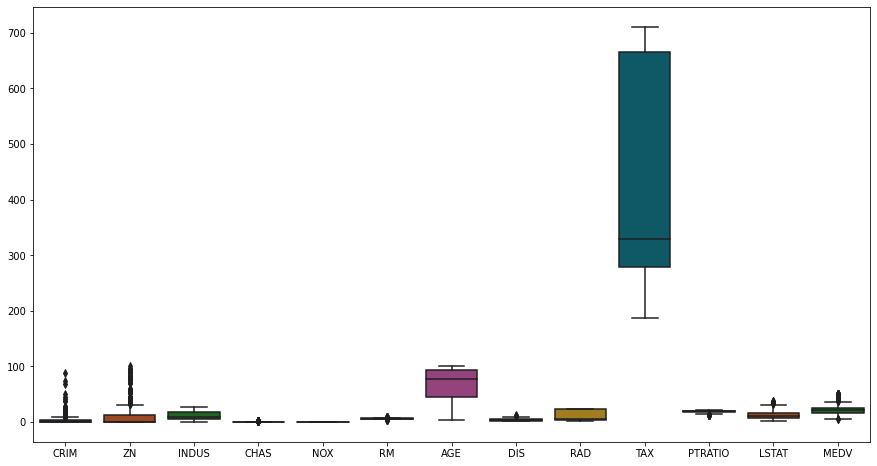

In [ ]:
# 4번 셀

# 상자그림
plt.figure(figsize=(15,8))
sns.boxplot(data=data, palette='dark')

      CRIM    ZN  INDUS  CHAS    NOX  ...  RAD  TAX  PTRATIO  LSTAT  MEDV
0  0.00632  18.0   2.31     0  0.538  ...    1  296     15.3   4.98  24.0
1  0.02731   0.0   7.07     0  0.469  ...    2  242     17.8   9.14  21.6
2  0.02729   0.0   7.07     0  0.469  ...    2  242     17.8   4.03  34.7
3  0.03237   0.0   2.18     0  0.458  ...    3  222     18.7   2.94  33.4
4  0.06905   0.0   2.18     0  0.458  ...    3  222     18.7   5.33  36.2

[5 rows x 13 columns]



         0         1         2   ...        10        11        12
0 -0.419782  0.284830 -1.287909  ... -1.459000 -1.075562  0.159686
1 -0.417339 -0.487722 -0.593381  ... -0.303094 -0.492439 -0.101524
2 -0.417342 -0.487722 -0.593381  ... -0.303094 -1.208727  1.324247
3 -0.416750 -0.487722 -1.306878  ...  0.113032 -1.361517  1.182758
4 -0.412482 -0.487722 -1.306878  ...  0.113032 -1.026501  1.487503

[5 rows x 13 columns]



                 0             1   ...            11            12
count  5.060000e+02  5.060000e+02  

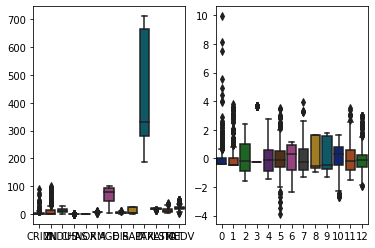

In [ ]:
# 5번 셀

print(data.head()) # Before Scalling
skip_three_rows()
# 데이터 스케일링 - StandardScaler
scaler = StandardScaler()
z_data = scaler.fit_transform(data)
# z-데이터를 numpy에서 pandas로 전환
z_data = pd.DataFrame(z_data)
print(z_data.head()) # After Scalling

skip_three_rows()
# z-점수 정규화 후 통계 출력 : mean=0, std=1 -> 표준정규분포
print(z_data.describe())

skip_three_rows()
# 상자그림 비교 
# plt.figure(figsize=(16,16))
fig, axes = plt.subplots(1,2)
sns.boxplot(data=data, ax=axes[0], palette='dark')
sns.boxplot(data=z_data, ax=axes[1], palette='dark')

In [ ]:
# 6번 셀

# 데이터를 입력과 출력으로 분할
X_data = z_data.drop(12, axis=1)
# print(X_data)
Y_data = z_data[12]
# print(Y_data)

# 데이터를 학습용과 평가용으로 분할
# 순서 중요
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    train_size=0.7)

print('학습용 입력 모양 : ', X_train.shape) # 실행 전 예측 : (506*0.7, 12)
print('학습용 출력 모양 : ', Y_train.shape) # 실행 전 예측 : (354,)
print('평가용 입력 모양 : ', X_test.shape) # 실행 전 예측 : (506*0.3, 12)
print('평가용 출력 모양 : ', Y_test.shape) # 실행 전 예측 : (152,)

학습용 입력 모양 :  (354, 12)
학습용 출력 모양 :  (354,)
평가용 입력 모양 :  (152, 12)
평가용 출력 모양 :  (152,)


In [ ]:
# 7번 셀 

# 인공신경망 구현
# Sequential 방식 : 입력부터 출력으로 한층 한층 추가하는 방식
model = Sequential()

# 입력층 + 은닉층 1 동시에 추가 : fully-connected -> 12*1000
model.add(Dense(units=MY_HIIDEN,
                input_dim=12,
                activation='relu'))

# 은닉층 2 추가
model.add(Dense(units=MY_HIIDEN,
                activation='relu'))

# 출력층 추가
model.add(Dense(units=1))

# DNN (deep neural network) 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1000)              13000     
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1,015,001
Trainable params: 1,015,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 8번 셀

# DNN 학습
# 학습 환경 설정

model.compile(optimizer='sgd',
              loss='mse')

# 학습진행 
print('학습 시작')
begin = time()

model.fit(X_train,
          Y_train,
          epochs=MY_EPOCH,
          verbose=1)

end = time()
print('총 학습 시간 :', end - begin)

학습 시작
Epoch 1/10
12/12 [==============================] - 2s 4ms/step - loss: 0.7289
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.4353
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.3436
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.2874
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.2517
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.2278
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.2091
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1962
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.1834
Epoch 10/10
12/12 [==============================] - 0s 4ms/step - loss: 0.1730
총 학습 시간 : 3.340855598449707


In [ ]:
# 9번 셀

# DNN 평가
score = model.evaluate(X_test,
                       Y_test)

print('최종 mse loss 값 : ', score) # 학습 loss != 평가 loss -> 일반적으로 평가 loss 가 더 큼.

5/5 [==============================] - 0s 4ms/step - loss: 0.1993
최종 mse loss 값 :  0.1992933303117752


In [ ]:
# 10번 셀

# DNN 에측
pred = model.predict(X_test)
print('첫번째 집값 예측 (Z-점수) : ', pred[0])
print('첫번째 집값 정답 (Z-점수) : ', Y_test[0])
print(pred.shape) # 152개 안에 value 하나씩있는 모양

첫번째 집값 예측 (Z-점수) :  [-1.6799939]
첫번째 집값 정답 (Z-점수) :  0.1596856587150597
(152, 1)
